In [2]:
%load_ext autoreload
%autoreload 2

import torch
import pyterrier as pt
import pandas as pd

from src.neural_ranker.ranker import NeuralRanker
from src.neural_ranker.produce_rankings import IRDataset, Processor
from src.llm.llm import OpenAILLM
from domain_adaptation import self_training_domain_adaptation
from main import llm_ranker, rank_with_base_model, contrastive_train_neural_ranker, rank_with_contrastive_model, pseudo_labels_fine_tune, rank_with_pseudo_labels_model
from eval import Model, evaluate_rankings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\viv16\Documents\GitHub\ranker_ir\eval.py:82: SyntaxWarning: invalid escape sequence '\e'
  pd.DataFrame([results]).to_csv(f"{save_location}\evaluation_results.csv", index=False)
c:\Users\viv16\Documents\GitHub\ranker_ir\eval.py:83: SyntaxWarning: invalid escape sequence '\e'
  print(f"\nEvaluation results saved to {save_location}\evaluation_results.csv")
c:\Users\viv16\Documents\GitHub\ranker_ir\eval.py:107: SyntaxWarning: invalid escape sequence '\p'
  per_query_results.to_csv(f"{save_location}\per_query_evaluation.csv", index=False)
c:\Users\viv16\Documents\GitHub\ranker_ir\eval.py:108: SyntaxWarning: invalid escape sequence '\p'
  print(f"\nPer-query evaluation results saved to {save_location}\per_query_evaluation.csv")
c:\Users\viv16\Documents\GitHub\ranker_ir\eval.py:121: SyntaxWarning: invalid escape sequence '\z'
  evaluate_rankings(ranked_results_path, dataset_name, metrics_cutoff=10, should_do_per_query=True, save_location="evaluation_results\zero_shot")


In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_mem_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
    gpu_mem_reserved = torch.cuda.memory_reserved(0) / 1024**3
    gpu_mem_allocated = torch.cuda.memory_allocated(0) / 1024**3
    gpu_mem_free = gpu_mem_total - gpu_mem_reserved
    print(f"GPU Memory: Total: {gpu_mem_total:.2f}GB, Reserved: {gpu_mem_reserved:.2f}GB, "
        f"Allocated: {gpu_mem_allocated:.2f}GB, Free: {gpu_mem_free:.2f}GB")

Using device: cuda
GPU Memory: Total: 4.00GB, Reserved: 0.00GB, Allocated: 0.00GB, Free: 4.00GB


In [4]:
bair = 'irds:beir/trec-covid'
cord19 = 'irds:cord19/trec-covid'

bair_dataset = IRDataset(bair, max_docs=None)
cord19_dataset = IRDataset(cord19, max_docs=None)

[INFO] [starting] building docstore


Loading up to None documents from irds:beir/trec-covid...


[INFO] [starting] opening zip file                                              
[INFO] If you have a local copy of https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/trec-covid.zip, you can symlink it here to avoid downloading it again: C:\Users\viv16\.ir_datasets\downloads\ce62140cb23feb9becf6270d0d1fe6d1
[INFO] [starting] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/trec-covid.zip
                                                                                
                                                                                                                          [INFO] [finished] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/trec-covid.zip: [00:10] [73.9MB] [7.02MB/s]
[INFO] [finished] opening zip file [10.69s]                                     
docs_iter: 100%|████████████████████| 171332/171332 [00:16<00:00, 10491.73doc/s]
[INFO] [finished] docs_iter: [00:16] [171332doc] [10491.73doc/s]
[INFO] [finished

Loading up to None documents from irds:cord19/trec-covid...


cord19/trec-covid documents: 100%|██████████| 192509/192509 [00:01<00:00, 134416.75it/s]
Loading Documents: 192509it [00:01, 134635.70it/s]


In [ ]:
queries = rank_with_base_model(cord19_dataset, device)

Checking for existing embeddings...
No existing embeddings found or file corrupted. Starting from scratch.

Processing chunk 1/39 (documents 0 to 4999)...


Encoding Chunk 1:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
evaluate_rankings(model=Model.BASE, dataset_name=cord19)

In [6]:
contrastive_train_neural_ranker(device=device)

Loading dataset...
Loading up to None documents from irds:beir/trec-covid...


beir/trec-covid documents: 100%|██████████| 171332/171332 [00:00<00:00, 318056.10it/s]
Loading Documents: 171332it [00:00, 318647.87it/s]


Processing documents...


Processing documents: 100%|██████████| 171332/171332 [00:00<00:00, 1146138.45it/s]


Loaded 171332 documents for contrastive training.

Initializing augmentor...
Creating contrastive dataset...

Creating dataloader...

Dataloader configuration: batch_size=8, num_workers=0

Initializing model...
Model has 109,482,240 trainable parameters

Initializing trainer...

Training for up to 3 epochs with early stopping (patience=2, min_delta=0.001)...


Epoch 1/3:   1%|▏         | 318/21417 [01:29<1:39:02,  3.55it/s, loss=0.0010]

Loss 0.000999 is below threshold. Stopping early.

Saving model to models/contrastive_model.pt...


Model saved successfully!


In [13]:
rank_with_contrastive_model(cord19_dataset, device)

c:\Users\bogda\Desktop\TU Delft\Q3\DSAIT4050-IR\research_project\ranker_ir\main.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ranker.load_state_dict(torch.load("mode

Checking for existing embeddings...
No existing embeddings found or file corrupted. Starting from scratch.

Processing chunk 1/39 (documents 0 to 4999)...


Encoding Chunk 1: 100%|██████████| 79/79 [00:24<00:00,  3.20it/s]



Processing chunk 2/39 (documents 5000 to 9999)...


Encoding Chunk 2: 100%|██████████| 79/79 [00:23<00:00,  3.39it/s]



Processing chunk 3/39 (documents 10000 to 14999)...


Encoding Chunk 3: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]



Processing chunk 4/39 (documents 15000 to 19999)...


Encoding Chunk 4: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]



Processing chunk 5/39 (documents 20000 to 24999)...


Encoding Chunk 5: 100%|██████████| 79/79 [00:22<00:00,  3.59it/s]



Processing chunk 6/39 (documents 25000 to 29999)...


Encoding Chunk 6: 100%|██████████| 79/79 [00:23<00:00,  3.35it/s]



Processing chunk 7/39 (documents 30000 to 34999)...


Encoding Chunk 7: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]



Processing chunk 8/39 (documents 35000 to 39999)...


Encoding Chunk 8: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]



Processing chunk 9/39 (documents 40000 to 44999)...


Encoding Chunk 9: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]



Processing chunk 10/39 (documents 45000 to 49999)...


Encoding Chunk 10: 100%|██████████| 79/79 [00:24<00:00,  3.23it/s]



Processing chunk 11/39 (documents 50000 to 54999)...


Encoding Chunk 11: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]



Processing chunk 12/39 (documents 55000 to 59999)...


Encoding Chunk 12: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]



Processing chunk 13/39 (documents 60000 to 64999)...


Encoding Chunk 13: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]



Processing chunk 14/39 (documents 65000 to 69999)...


Encoding Chunk 14: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 15/39 (documents 70000 to 74999)...


Encoding Chunk 15: 100%|██████████| 79/79 [00:24<00:00,  3.25it/s]



Processing chunk 16/39 (documents 75000 to 79999)...


Encoding Chunk 16: 100%|██████████| 79/79 [00:24<00:00,  3.25it/s]



Processing chunk 17/39 (documents 80000 to 84999)...


Encoding Chunk 17: 100%|██████████| 79/79 [00:24<00:00,  3.26it/s]



Processing chunk 18/39 (documents 85000 to 89999)...


Encoding Chunk 18: 100%|██████████| 79/79 [00:24<00:00,  3.26it/s]



Processing chunk 19/39 (documents 90000 to 94999)...


Encoding Chunk 19: 100%|██████████| 79/79 [00:23<00:00,  3.33it/s]



Processing chunk 20/39 (documents 95000 to 99999)...


Encoding Chunk 20: 100%|██████████| 79/79 [00:23<00:00,  3.32it/s]



Processing chunk 21/39 (documents 100000 to 104999)...


Encoding Chunk 21: 100%|██████████| 79/79 [00:23<00:00,  3.29it/s]



Processing chunk 22/39 (documents 105000 to 109999)...


Encoding Chunk 22: 100%|██████████| 79/79 [00:23<00:00,  3.30it/s]



Processing chunk 23/39 (documents 110000 to 114999)...


Encoding Chunk 23: 100%|██████████| 79/79 [00:23<00:00,  3.32it/s]



Processing chunk 24/39 (documents 115000 to 119999)...


Encoding Chunk 24: 100%|██████████| 79/79 [00:24<00:00,  3.29it/s]



Processing chunk 25/39 (documents 120000 to 124999)...


Encoding Chunk 25: 100%|██████████| 79/79 [00:23<00:00,  3.33it/s]



Processing chunk 26/39 (documents 125000 to 129999)...


Encoding Chunk 26: 100%|██████████| 79/79 [00:23<00:00,  3.31it/s]



Processing chunk 27/39 (documents 130000 to 134999)...


Encoding Chunk 27: 100%|██████████| 79/79 [00:24<00:00,  3.29it/s]



Processing chunk 28/39 (documents 135000 to 139999)...


Encoding Chunk 28: 100%|██████████| 79/79 [00:24<00:00,  3.25it/s]



Processing chunk 29/39 (documents 140000 to 144999)...


Encoding Chunk 29: 100%|██████████| 79/79 [00:24<00:00,  3.26it/s]



Processing chunk 30/39 (documents 145000 to 149999)...


Encoding Chunk 30: 100%|██████████| 79/79 [00:24<00:00,  3.25it/s]



Processing chunk 31/39 (documents 150000 to 154999)...


Encoding Chunk 31: 100%|██████████| 79/79 [00:24<00:00,  3.25it/s]



Processing chunk 32/39 (documents 155000 to 159999)...


Encoding Chunk 32: 100%|██████████| 79/79 [00:24<00:00,  3.26it/s]



Processing chunk 33/39 (documents 160000 to 164999)...


Encoding Chunk 33: 100%|██████████| 79/79 [00:25<00:00,  3.15it/s]



Processing chunk 34/39 (documents 165000 to 169999)...


Encoding Chunk 34: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 35/39 (documents 170000 to 174999)...


Encoding Chunk 35: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]



Processing chunk 36/39 (documents 175000 to 179999)...


Encoding Chunk 36: 100%|██████████| 79/79 [00:25<00:00,  3.10it/s]



Processing chunk 37/39 (documents 180000 to 184999)...


Encoding Chunk 37: 100%|██████████| 79/79 [00:25<00:00,  3.09it/s]



Processing chunk 38/39 (documents 185000 to 189999)...


Encoding Chunk 38: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]



Processing chunk 39/39 (documents 190000 to 192508)...


Encoding Chunk 39: 100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Completed processing 192509 documents.
Document encoding complete. Now ranking queries...
There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Loaded 50 queries
Ranking 50 queries against 192509 documents...


Ranking Queries: 100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


In [ ]:
evaluate_rankings(model=Model.CONTRASTIVE, dataset_name=cord19)

Evaluating rankings with metrics@10...
Loaded 9625450 ranking entries

=== Evaluation Results ===
map: 0.1859
ndcg: 0.6866
ndcg_cut_10: 0.6570
P_10: 0.6880
recall_10: 0.0165
recip_rank: 0.8403

Evaluation results saved to evaluation_results/base\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.1281
    recip_rank: 1.0000
    P_10: 0.5000
    recall_10: 0.0072
    ndcg: 0.6776
    ndcg_cut_10: 0.4959
-------------------------

Query 2:
    map: 0.0585
    recip_rank: 0.5000
    P_10: 0.6000
    recall_10: 0.0179
    ndcg: 0.5997
    ndcg_cut_10: 0.5527
-------------------------

Query 3:
    map: 0.1977
    recip_rank: 1.0000
    P_10: 0.9000
    recall_10: 0.0138
    ndcg: 0.7465
    ndcg_cut_10: 0.9364
-------------------------

Query 4:
    map: 0.0535
    recip_rank: 0.1000
    P_10: 0.1000
    recall_10: 0.0018
    ndcg: 0.5830
    ndcg_cut_10: 0.0636
-------------------------

Query 5:
    map: 0.1349
    recip_rank: 0.3333
    P_10: 0.4000
    recall_10: 

{'map': 0.18585182567772524,
 'ndcg': 0.6865586940416332,
 'ndcg_cut_10': 0.6569951008404138,
 'P_10': 0.6879999999999998,
 'recall_10': 0.01649486349187759,
 'recip_rank': 0.840343137254902}

In [ ]:
%autoreload
pseudo_labels_fine_tune(dataset=cord19_dataset, device=device)

Evaluating rankings with metrics@10...
Loaded 9625450 ranking entries

=== Evaluation Results ===
map: 0.0033
ndcg: 0.4235
ndcg_cut_10: 0.0000
P_10: 0.0000
recall_10: 0.0000
recip_rank: 0.0026

Evaluation results saved to evaluation_results/contrastive\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.0046
    recip_rank: 0.0021
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.4614
    ndcg_cut_10: 0.0000
-------------------------

Query 2:
    map: 0.0060
    recip_rank: 0.0078
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.4451
    ndcg_cut_10: 0.0000
-------------------------

Query 3:
    map: 0.0031
    recip_rank: 0.0004
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.4277
    ndcg_cut_10: 0.0000
-------------------------

Query 4:
    map: 0.0031
    recip_rank: 0.0022
    P_10: 0.0000
    recall_10: 0.0000
    ndcg: 0.4253
    ndcg_cut_10: 0.0000
-------------------------

Query 5:
    map: 0.0036
    recip_rank: 0.0002
    P_10: 0.0000
    reca

{'map': 0.003338411312322189,
 'ndcg': 0.42352346833935955,
 'ndcg_cut_10': 0.0,
 'P_10': 0.0,
 'recall_10': 0.0,
 'recip_rank': 0.002590893580737511}

In [ ]:
rank_with_pseudo_labels_model(cord19_dataset, device)

Document encoding complete. Now ranking queries...
There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Loaded 50 queries
Using index path: c:\Users\bogda\Desktop\TU Delft\Q3\DSAIT4050-IR\research_project\ranker_ir\index\trec-covid
12:29:49.238 [main] WARN org.terrier.structures.FSADocumentIndex -- This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored
Index loaded from: c:\Users\bogda\Desktop\TU Delft\Q3\DSAIT4050-IR\research_project\ranker_ir\index\trec-covid
Starting fine-tuning on pseudo labels...


100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


Epoch 1/3 - Loss: 25.1082


100%|██████████| 50/50 [00:04<00:00, 11.63it/s]


Epoch 2/3 - Loss: 24.9611


100%|██████████| 50/50 [00:04<00:00, 11.96it/s]


Epoch 3/3 - Loss: 25.0047
Fine-tuning complete.
Domain adaptation complete.

Saving model to models/pseudo_labels_model.pt...
Model saved successfully!


In [ ]:
evaluate_rankings(model=Model.PSEUDO_LABELS, dataset_name=cord19)

c:\Users\bogda\Desktop\TU Delft\Q3\DSAIT4050-IR\research_project\ranker_ir\main.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  


Checking for existing embeddings...
No existing embeddings found or file corrupted. Starting from scratch.

Processing chunk 1/39 (documents 0 to 4999)...


Encoding Chunk 1: 100%|██████████| 79/79 [00:24<00:00,  3.20it/s]



Processing chunk 2/39 (documents 5000 to 9999)...


Encoding Chunk 2: 100%|██████████| 79/79 [00:23<00:00,  3.36it/s]



Processing chunk 3/39 (documents 10000 to 14999)...


Encoding Chunk 3: 100%|██████████| 79/79 [00:23<00:00,  3.34it/s]



Processing chunk 4/39 (documents 15000 to 19999)...


Encoding Chunk 4: 100%|██████████| 79/79 [00:21<00:00,  3.73it/s]



Processing chunk 5/39 (documents 20000 to 24999)...


Encoding Chunk 5: 100%|██████████| 79/79 [00:22<00:00,  3.59it/s]



Processing chunk 6/39 (documents 25000 to 29999)...


Encoding Chunk 6: 100%|██████████| 79/79 [00:23<00:00,  3.33it/s]



Processing chunk 7/39 (documents 30000 to 34999)...


Encoding Chunk 7: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 8/39 (documents 35000 to 39999)...


Encoding Chunk 8: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 9/39 (documents 40000 to 44999)...


Encoding Chunk 9: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 10/39 (documents 45000 to 49999)...


Encoding Chunk 10: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]



Processing chunk 11/39 (documents 50000 to 54999)...


Encoding Chunk 11: 100%|██████████| 79/79 [00:24<00:00,  3.27it/s]



Processing chunk 12/39 (documents 55000 to 59999)...


Encoding Chunk 12: 100%|██████████| 79/79 [00:24<00:00,  3.27it/s]



Processing chunk 13/39 (documents 60000 to 64999)...


Encoding Chunk 13: 100%|██████████| 79/79 [00:24<00:00,  3.26it/s]



Processing chunk 14/39 (documents 65000 to 69999)...


Encoding Chunk 14: 100%|██████████| 79/79 [00:24<00:00,  3.20it/s]



Processing chunk 15/39 (documents 70000 to 74999)...


Encoding Chunk 15: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]



Processing chunk 16/39 (documents 75000 to 79999)...


Encoding Chunk 16: 100%|██████████| 79/79 [00:24<00:00,  3.28it/s]



Processing chunk 17/39 (documents 80000 to 84999)...


Encoding Chunk 17: 100%|██████████| 79/79 [00:24<00:00,  3.28it/s]



Processing chunk 18/39 (documents 85000 to 89999)...


Encoding Chunk 18: 100%|██████████| 79/79 [00:24<00:00,  3.28it/s]



Processing chunk 19/39 (documents 90000 to 94999)...


Encoding Chunk 19: 100%|██████████| 79/79 [00:23<00:00,  3.36it/s]



Processing chunk 20/39 (documents 95000 to 99999)...


Encoding Chunk 20: 100%|██████████| 79/79 [00:23<00:00,  3.33it/s]



Processing chunk 21/39 (documents 100000 to 104999)...


Encoding Chunk 21: 100%|██████████| 79/79 [00:24<00:00,  3.28it/s]



Processing chunk 22/39 (documents 105000 to 109999)...


Encoding Chunk 22: 100%|██████████| 79/79 [00:24<00:00,  3.27it/s]



Processing chunk 23/39 (documents 110000 to 114999)...


Encoding Chunk 23: 100%|██████████| 79/79 [00:24<00:00,  3.28it/s]



Processing chunk 24/39 (documents 115000 to 119999)...


Encoding Chunk 24: 100%|██████████| 79/79 [00:24<00:00,  3.26it/s]



Processing chunk 25/39 (documents 120000 to 124999)...


Encoding Chunk 25: 100%|██████████| 79/79 [00:24<00:00,  3.29it/s]



Processing chunk 26/39 (documents 125000 to 129999)...


Encoding Chunk 26: 100%|██████████| 79/79 [00:23<00:00,  3.31it/s]



Processing chunk 27/39 (documents 130000 to 134999)...


Encoding Chunk 27: 100%|██████████| 79/79 [00:23<00:00,  3.31it/s]



Processing chunk 28/39 (documents 135000 to 139999)...


Encoding Chunk 28: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]



Processing chunk 29/39 (documents 140000 to 144999)...


Encoding Chunk 29: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]



Processing chunk 30/39 (documents 145000 to 149999)...


Encoding Chunk 30: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 31/39 (documents 150000 to 154999)...


Encoding Chunk 31: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]



Processing chunk 32/39 (documents 155000 to 159999)...


Encoding Chunk 32: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 33/39 (documents 160000 to 164999)...


Encoding Chunk 33: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 34/39 (documents 165000 to 169999)...


Encoding Chunk 34: 100%|██████████| 79/79 [00:24<00:00,  3.20it/s]



Processing chunk 35/39 (documents 170000 to 174999)...


Encoding Chunk 35: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]



Processing chunk 36/39 (documents 175000 to 179999)...


Encoding Chunk 36: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]



Processing chunk 37/39 (documents 180000 to 184999)...


Encoding Chunk 37: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]



Processing chunk 38/39 (documents 185000 to 189999)...


Encoding Chunk 38: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]



Processing chunk 39/39 (documents 190000 to 192508)...


Encoding Chunk 39: 100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


Completed processing 192509 documents.
Document encoding complete. Now ranking queries...
There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Loaded 50 queries
Ranking 50 queries against 192509 documents...


Ranking Queries: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


In [ ]:
llm_ranker(queries, cord19_dataset)

Evaluating rankings with metrics@10...
Loaded 9625450 ranking entries

=== Evaluation Results ===
map: 0.1888
ndcg: 0.6883
ndcg_cut_10: 0.6625
P_10: 0.7020
recall_10: 0.0169
recip_rank: 0.8198

Evaluation results saved to evaluation_results/pseudo_labels\evaluation_results.csv

Per-query evaluation results:
Query 1:
    map: 0.1358
    recip_rank: 1.0000
    P_10: 0.6000
    recall_10: 0.0086
    ndcg: 0.6819
    ndcg_cut_10: 0.5800
-------------------------

Query 2:
    map: 0.0625
    recip_rank: 1.0000
    P_10: 0.7000
    recall_10: 0.0209
    ndcg: 0.6106
    ndcg_cut_10: 0.7026
-------------------------

Query 3:
    map: 0.2100
    recip_rank: 1.0000
    P_10: 0.9000
    recall_10: 0.0138
    ndcg: 0.7531
    ndcg_cut_10: 0.9337
-------------------------

Query 4:
    map: 0.0578
    recip_rank: 0.1111
    P_10: 0.1000
    recall_10: 0.0018
    ndcg: 0.5902
    ndcg_cut_10: 0.0663
-------------------------

Query 5:
    map: 0.1314
    recip_rank: 0.3333
    P_10: 0.4000
    re

{'map': 0.1887953107218108,
 'ndcg': 0.6882588277061259,
 'ndcg_cut_10': 0.6625117493851265,
 'P_10': 0.7019999999999998,
 'recall_10': 0.016896036984225843,
 'recip_rank': 0.8198207251685513}

In [ ]:
evaluate_rankings(model=Model.LLMZERO, dataset_name=cord19)

In [ ]:
base_results = pd.read_csv('evaluation_results/base/evaluation_results.csv')
contrastive_results = pd.read_csv('evaluation_results/contrastive/evaluation_results.csv')
pseudo_labels_results = pd.read_csv('evaluation_results/pseudo_labels/evaluation_results.csv')
llm_zero_results = pd.read_csv('evaluation_results/llm_zero/evaluation_results.csv')
llm_few_results = pd.read_csv('evaluation_results/llm_few/evaluation_results.csv')

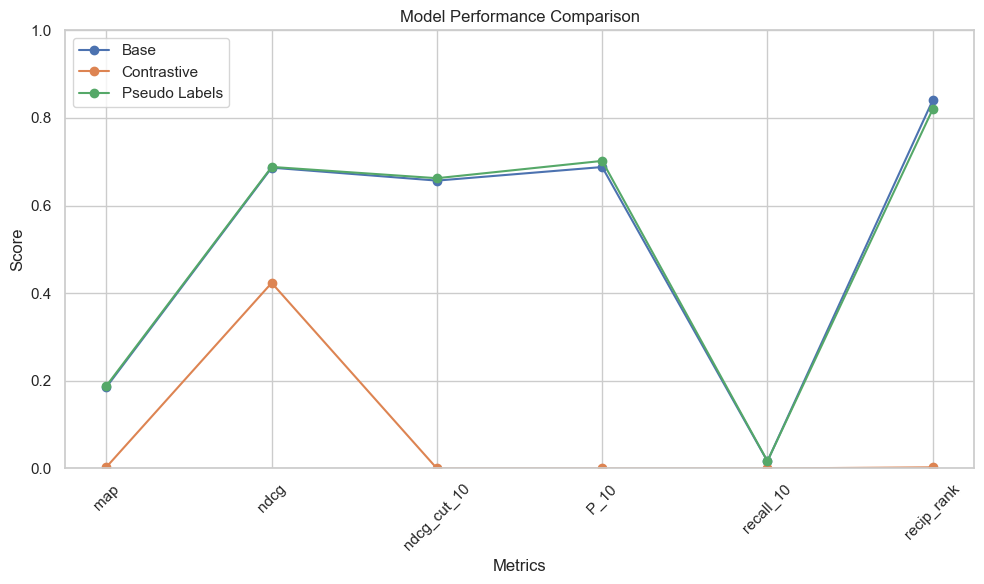

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['map', 'ndcg', 'ndcg_cut_10', 'P_10', 'recall_10', 'recip_rank']

# create a line for each model that goes through the metrics results
# and add the model name as a label
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

for model_results, label in zip([base_results, contrastive_results, pseudo_labels_results, llm_zero_results, llm_few_results], ['Base', 'Contrastive', 'Pseudo Labels', 'LLM Zero-shot', 'LLM Few-shot']):
    plt.plot(metrics, model_results[metrics].values.flatten(), marker='o', label=label)

plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()